**PBS ADSORPTION STUDIES**

Rodrigo Toledo de Araujo \\
 Department of Electrical Engineering and Computation \\
 University of Campina Grande \\
 Campina Grande, Paraíba, Brazil

 rodrigo.araujo@ee.ufcg.edu.br

# 0. Molecular Analysis and Dilution

Molarity ($M$) is defined as the number of moles of solute ($n$) per liter of solution ($V$).

\begin{equation}
M = \frac{n}{V}
\end{equation}

The relationship between moles ($n$), mass ($m$), and molar mass ($M_m$), is shown in \autoref{eq:moles}.

\begin{equation}
n = \frac{m}{M_m}
\end{equation}

\autoref{eq: mass} is typically used to find the required mass ($m$) for the proposed molarity (Combining \autoref{eq:molarity} and \autoref{eq:moles}).

\begin{equation}
m = M \times V \times M_m
\end{equation}

As in the NaOH experiment, the different concentrations of NaOH were produced by making a dilution of one bigger concentration (See \autoref{eq:dilution} for more details).

\begin{equation}
    C_{\text{new}}V_{\text{new}} = C_{\text{initial}}V_{\text{initial}}
\end{equation}

# 1. Importing Libraries

In [1]:
# Importing Libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
from cycler import cycler
import re
import jax
import jax.numpy as jnp
from typing import Callable, List
import subprocess
import os
import psutil
import tracemalloc
import subprocess

In [2]:
# Testing the backend
# Comando para obter informações sobre a GPU usando nvidia-smi
command = "nvidia-smi --query-gpu=name,memory.total --format=csv,noheader,nounits"
# Execute o comando e capture a saída
output = subprocess.check_output(command, shell=True, encoding="utf-8")
# Separe as linhas da saída
lines = output.strip().split("\n")
# imprima as informações da saída
for idx, line in enumerate(lines):
    name, memory = line.strip().split(",")
    print(f"GPU {idx} - Nome: {name}, Memória Total: {memory} MB")
    print(f"Jax backend:{jax.default_backend()}")
jax.devices()

GPU 0 - Nome: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Memória Total:  6144 MB
Jax backend:cpu


[CpuDevice(id=0)]

In [3]:
# Use LaTeX for text rendering
# Define a more scientific color cycle
scientific_colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "axes.labelsize": 12,
        "font.size": 10,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.prop_cycle": cycler(color=scientific_colors),
    }
)

# 2. Fitting the HCL data into the Langmuir Model

## 2.1 Theory

In 1932, Langmuir developed the Langmuir adsorption isotherm, which describes the adsorption and desorption of molecules on a surface \cite{langmuir1932vapor}.

Following the principles of physical chemistry for reaction kinetics and thermodynamics the change in the amount of solute adsorbed on a surface per unit area over time can be expressed in the following equation \cite{latour2015langmuir}.



$$\frac{dq}{dt} = k_aC(Q-q)-k_dq$$


where $C$ is the solution concentration, $Q$ is the amount of solute adsorbed when all of the biding sites are filled, $q$ is the amount of solute adsorbed on the surface given a solution concentration $C$, $t$ is the time and $(Q-q)$ is the number of vacant sites for adsorption.

Under dynamic equilibrium conditions, $dq/dt=0$, the equilibrium constant and $q$ are given by:

$$K_A=\frac{k_a}{k_d} = \frac{q}{C(Q-q)}$$

$$q =\frac{QC}{C+K_A^{-1}}$$

The following equation is used  to quantify adsorption coverage (i.e. normalized coverage $0<\Theta<1$).

$$\Theta = \frac{\text{Occupied region}}{\text{Total available region}} = \frac{q}{Q}=\frac{V_a}{V_m} = \frac{m_a}{m_m}$$

where $\Theta $ represents the coverage of the surface, $ V_a $ is the volume of the adsorbate adhered, $ V_m $ is the maximum volume of adsorbate in a monolayer, $ m_a $ is the number of moles adhered, and $ m_m $ is the maximum number of moles of adsorbate in a monolayer.

Then, the first order differential equation (i.e. Langmuir isotherm) in terms of the normalized coverage is:

$$\frac{d(q/Q)}{dt}=\frac{d\Theta}{dt} = k_aC(1-\Theta)-k_d\Theta$$

And has exponential solutions (i.e. $\Theta(t)$) given by:

   $$ \Theta(t) = \left(\frac{k_aC}{k_aC+k_d}\right)\left(1-e^{-({k_aC+k_d})t}\right), \quad \text{or}\quad
\Theta(t) = \left(\frac{C}{C+K_A^{-1}}\right)\left(1-e^{-({k_aC+k_d})t}\right)$$

The molecular surface under steady state conditions, from the previous equation is given by:

$$\Theta^\infty=\lim_{t\rightarrow\infty}\Theta(t)=\frac{C}{C+K_A^{-1}}$$




## 2.2 Finding Initial Values

### A. Theory

The effective refractive index variation $\Delta \mathcal{N}_s^{\text{eff}}$ can be estimated by using the surface coverage (i.e., $\Theta_{\text{mol}}(C_s)$, derived from one of the adsorption models) as shown in the following equation:

$$\Delta \mathcal{N}_s^{\text{eff}}(C_s) = \Delta \mathcal{N}_{\text{mol}}^{\text{max}}\Theta_{\text{mol}}(C_s)$$

Being:

$$\Theta_{\text{mol}}(C)=\frac{C}{C+K_A^{-1}}\theta_\infty$$

Then:

$$\Delta \mathcal{N}_s^{\text{eff}} = \Delta \mathcal{N}_{\text{mol}}^{\text{max}}\frac{C}{C+K_A^{-1}}\theta_{\infty} \longrightarrow\Delta \mathcal{N}_s^{\text{eff}}K_A^{-1}-\Delta \mathcal{N}_{\text{mol}}^{\text{max}}\theta_{\infty} C=-C\Delta \mathcal{N}_s^{\text{eff}}$$

Using the information of two points: ($C_1$, $\Delta \mathcal{N}_{s1}^{\text{eff}}$) and ($C_2$, $\Delta \mathcal{N}_{s2}^{\text{eff}}$), a linear set of equations can be derived (In the matrix form):

$$
  \begin{bmatrix}
\Delta \mathcal{N}_{s1}^{\text{eff}} & -C_1\\
\Delta \mathcal{N}_{s2}^{\text{eff}} & -C_2
\end{bmatrix}\begin{bmatrix}
K_A^{-1}\\
\Delta \mathcal{N}_{\text{mol}}^{\text{max}}\theta_{\infty}
\end{bmatrix}=\begin{bmatrix}
-C_1\Delta \mathcal{N}_{s1}^{\text{eff}}\\
-C_2\Delta \mathcal{N}_{s2}^{\text{eff}}
\end{bmatrix}  
$$

Where:

* $\Delta \mathcal{N}_{\text{mol}}^{\text{max}}$, $\theta_{\infty}$  and $K_A^{-1}$ are the constant unknowns
* $C$ and $\Delta \mathcal{N}_s^{\text{eff}}$ are the coefficients (we already know their values) that vary.

Given that the values of the two points [($C_1$, $\Delta \mathcal{N}_{s1}^{\text{eff}}$) and ($C_2$, $\Delta \mathcal{N}_{s2}^{\text{eff}}$)] are known, by using a numerical method (e.g., Gauss method), the unknown variables are quickly defined.

### B. Importing data and visualization

In [4]:
# Step 2: Define the directory containing the Excel files
dir_path = "Data\Data_HCL\data_excel"

# Step 3: Initialize an empty dictionary to store data
data_dict = {}

# Step 4: List all files in the directory
file_list = os.listdir(dir_path)

file_list = sorted(file_list)

# Step 6: Loop through the sorted files and read each Excel file into the dictionary
for file_name in file_list:
    if file_name.endswith(".xlsx"):
        file_path = os.path.join(dir_path, file_name)
        data_dict[file_name] = pd.read_excel(file_path)

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Rodrigo Toledo\AppData\Local\Temp\ipykernel_20056\699836678.py:2: SyntaxWarning: invalid escape sequence '\D'
  dir_path = "Data\Data_HCL\data_excel"


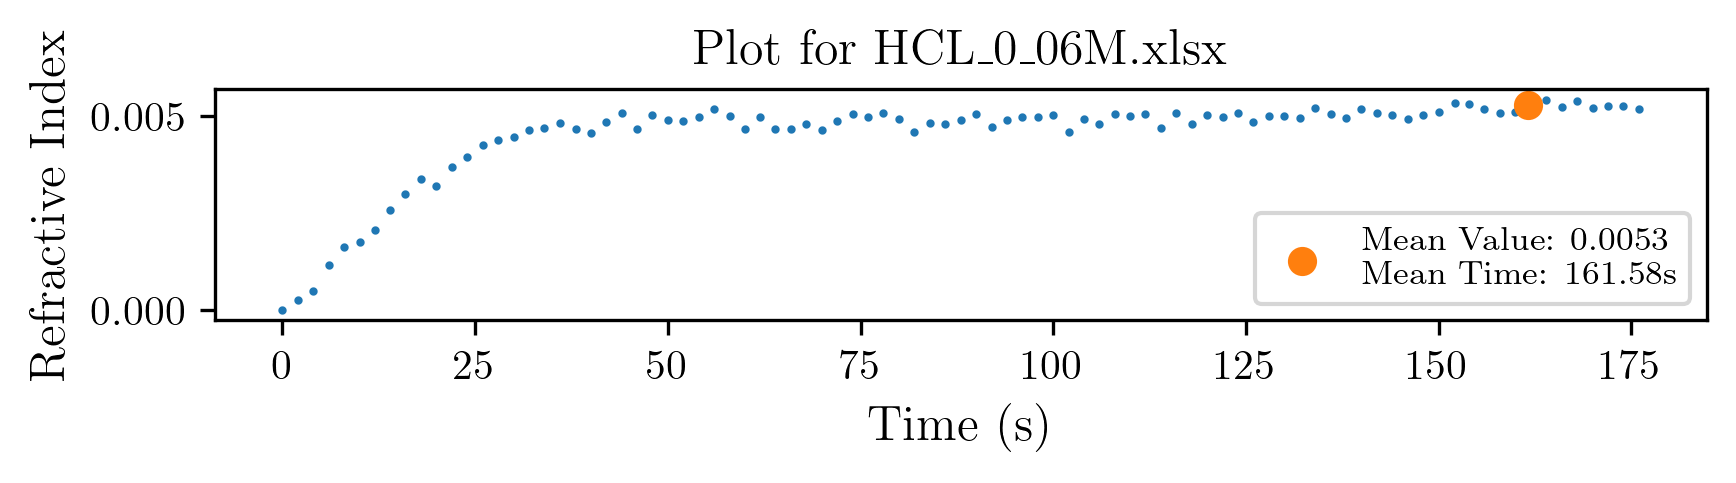

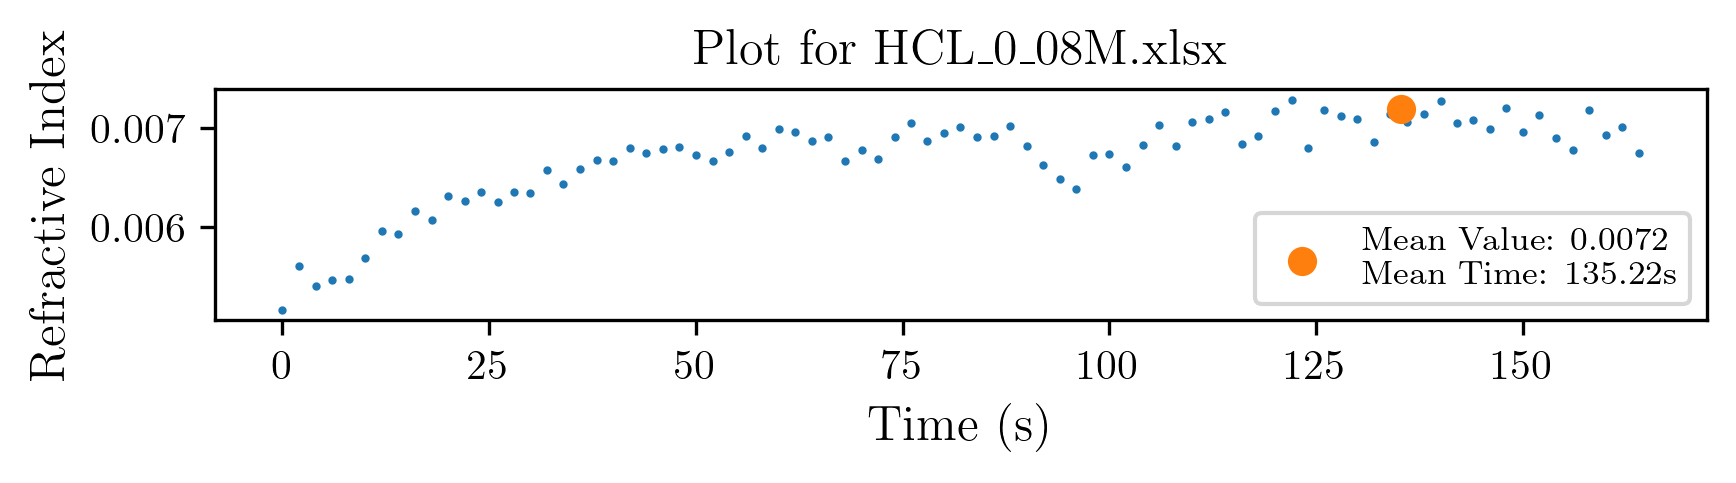

In [5]:
max_values_dict = {}
concentration = [0.06, 0.08]
window_size = 10  # Set this to the number of top values you want to average
time_array = []
refrac_index_array = []

for i, (file_name, data) in enumerate(data_dict.items()):
    # Getting the time and the refractive index
    time = data["Time"] / 1e3
    refrac_var = data[" Refractive Index"] / 1e3
    refrac_index_array.append(refrac_var)
    time_array.append(time)
    # Sort the refractive index and get the indices of the top 'window_size' values
    top_indices = refrac_var.nlargest(window_size).index

    # Get the mean of the top 'window_size' refractive index values and corresponding times
    mean_value = refrac_var.loc[top_indices].mean()
    mean_time = time.loc[top_indices].mean()

    # Store the mean values in the dictionary
    max_values_dict[file_name] = {
        "mean_value": mean_value,
        "mean_time": mean_time,
        "concentration": concentration[i],  # Add the corresponding concentration
    }

    # Plotting the time versus refractive index
    fig, ax = plt.subplots(figsize=(6.417, 1), dpi=300)
    ax.scatter(time, refrac_var, s=1)
    ax.scatter(
        mean_time,
        mean_value,
        label=f"Mean Value: {mean_value:.4f}\nMean Time: {mean_time:.2f}s",
    )
    ax.set_ylabel("Refractive Index")
    ax.set_xlabel("Time (s)")
    ax.legend(fontsize=8)

    # Add a title with the file name for reference
    ax.set_title(f"Plot for {file_name}")

    # Show the plot
    plt.show()


In [12]:
refrac_index_array

[0     0.000000
 1     0.000269
 2     0.000495
 3     0.001167
 4     0.001631
         ...   
 84    0.005400
 85    0.005204
 86    0.005257
 87    0.005253
 88    0.005186
 Name:  Refractive Index, Length: 89, dtype: float64,
 0     0.005159
 1     0.005609
 2     0.005398
 3     0.005466
 4     0.005474
         ...   
 78    0.006778
 79    0.007187
 80    0.006929
 81    0.007013
 82    0.006745
 Name:  Refractive Index, Length: 83, dtype: float64]

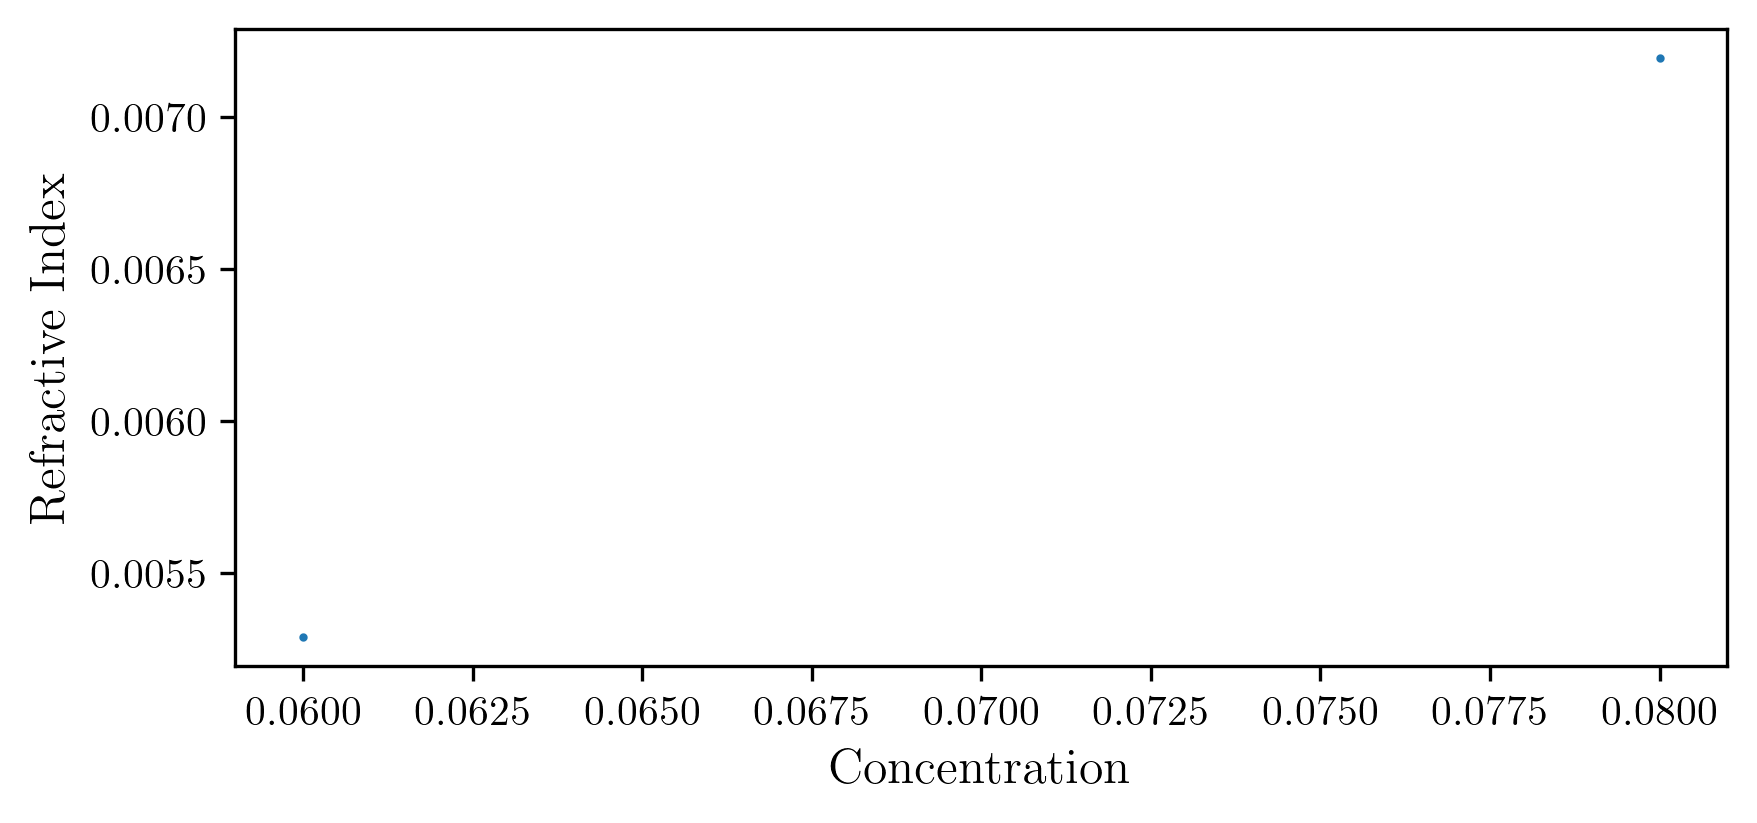

In [6]:
# Plotting the maximum value over the concentration
fig, ax = plt.subplots(figsize=(6.417, 2.7559), dpi=300)
ax.set_ylabel("Refractive Index")
ax.set_xlabel("Concentration")
max_values = []
for file_name, data in max_values_dict.items():
    max_values.append(data["mean_value"])
    ax.scatter(data["concentration"], data["mean_value"], s=1, color="#1f77b4")

C1 = max_values_dict["HCL_0_06M.xlsx"]["concentration"]
C2 = max_values_dict["HCL_0_08M.xlsx"]["concentration"]
R1 = max_values_dict["HCL_0_06M.xlsx"]["mean_value"]
R2 = max_values_dict["HCL_0_08M.xlsx"]["mean_value"]

### C. Finding $K_a$ and $\Delta \mathcal{N}_{\text{mol}}^{\text{max}}$

Using the information of two points: ($C_1$, $\Delta \mathcal{N}_{s1}^{\text{eff}}$) and ($C_2$, $\Delta \mathcal{N}_{s2}^{\text{eff}}$), a linear set of equations can be derived (In the matrix form):

$$
  \begin{bmatrix}
\Delta \mathcal{N}_{s1}^{\text{eff}} & -C_1\\
\Delta \mathcal{N}_{s2}^{\text{eff}} & -C_2
\end{bmatrix}\begin{bmatrix}
K_A^{-1}\\
\Delta \mathcal{N}_{\text{mol}}^{\text{max}}\theta_{\infty}
\end{bmatrix}=\begin{bmatrix}
-C_1\Delta \mathcal{N}_{s1}^{\text{eff}}\\
-C_2\Delta \mathcal{N}_{s2}^{\text{eff}}
\end{bmatrix}  
$$

In [7]:
C1 = max_values_dict["HCL_0_06M.xlsx"]["concentration"]
C2 = max_values_dict["HCL_0_08M.xlsx"]["concentration"]
R1 = max_values_dict["HCL_0_06M.xlsx"]["mean_value"]
R2 = max_values_dict["HCL_0_08M.xlsx"]["mean_value"]
A = np.array([[R1, -C1], [R2, -C2]])
B = np.array([-C1 * R1, -C2 * R2])
S = np.linalg.solve(A, B)
Ka = S[0] ** (-1)
var_n_mol_thetainf = S[1]

In [8]:
Constants_1 = {
    "Ns1": [R1],
    "C1": [C1],
    "Ns2": [R2],
    "C2": [C2],
    "KA": [np.abs(Ka)],
    "Nmol": [np.abs(var_n_mol_thetainf)],
}

df_Constants_1 = pd.DataFrame(Constants_1)
df_Constants_1

,Ns1,C1,Ns2,C2,KA,Nmol
0,0.005291,0.06,0.007191,0.08,0.899635,0.092728


## 2.3 RLS Method

### A. Algorithm without jax

Performance Metrics:
Total execution time: 0.27 seconds
Initialization time: 0.14 seconds
RLS computation time: 0.014232 seconds
Average iteration time per experiment: 0.000080 seconds
Peak CPU memory usage: 1.86 MB
GPU memory usage (MB):
  - Total: 6.00
  - Used: 0.19
  - Free: 5.67
Change in GPU memory usage: 0.00 MB


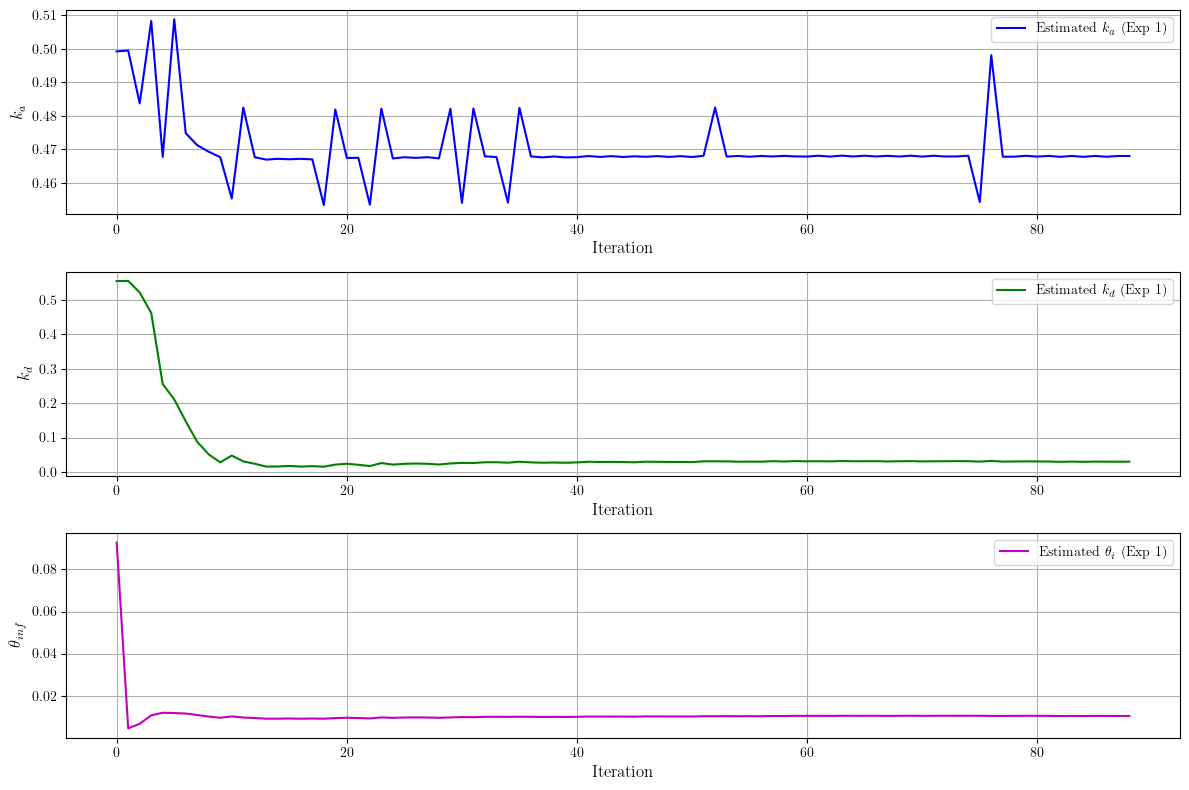

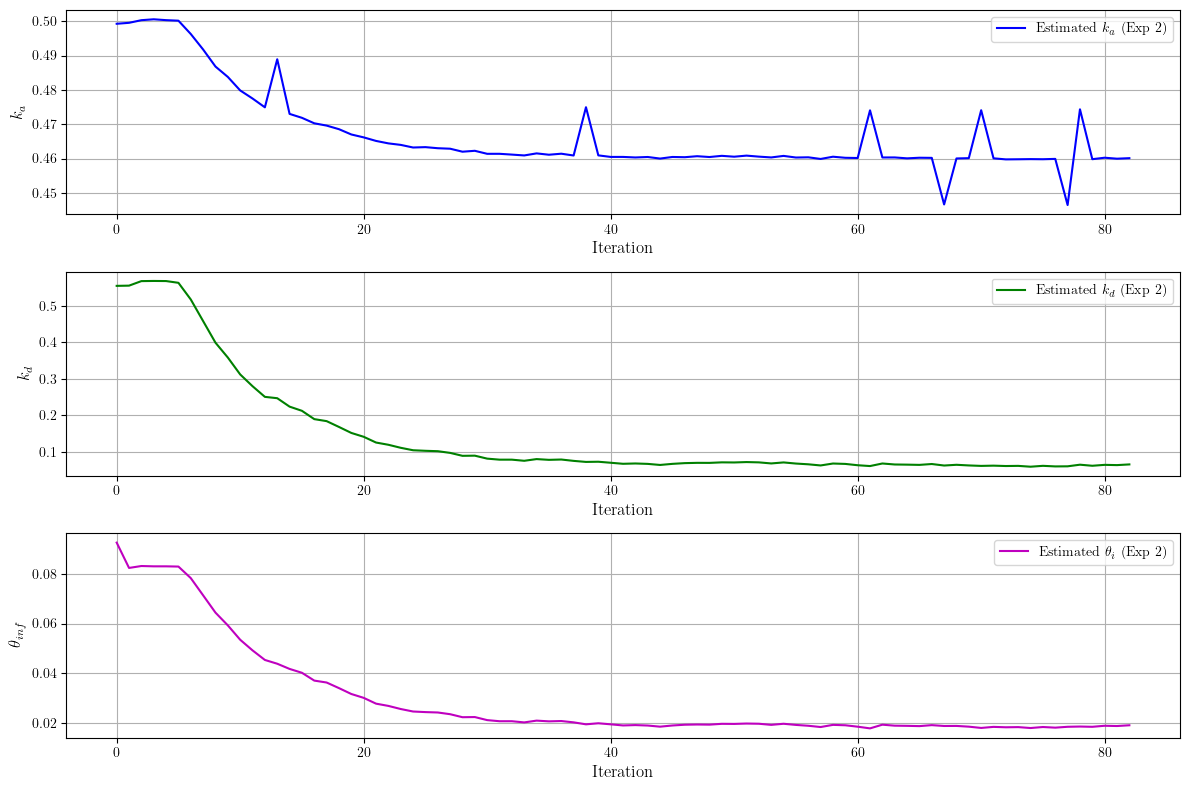

In [9]:
# Function to measure GPU memory usage using nvidia-smi
import time

def get_gpu_memory():
    try:
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=memory.total,memory.used,memory.free", "--format=csv,nounits,noheader"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
        )
        if result.returncode == 0:
            total, used, free = map(int, result.stdout.strip().split("\n")[0].split(", "))
            return {"total": total, "used": used, "free": free}
        else:
            print("Error querying GPU memory:", result.stderr)
            return {"total": 0, "used": 0, "free": 0}
    except FileNotFoundError:
        print("nvidia-smi not found. GPU memory monitoring unavailable.")
        return {"total": 0, "used": 0, "free": 0}

# Start monitoring
tracemalloc.start()
start_time = time.time()
initial_gpu_memory = get_gpu_memory()

# Define constants and initialize parameters
init_start_time = time.time()

# Generate synthetic data for multiple experiments
C_values = [0.06, 0.08]

n_experiments = len(C_values)  # Number of experiments
Concentration_anti = jnp.array(C_values)

# Generate step-like inputs for each experiment
u_list = []
dt_list = []
for i in range(n_experiments):
    u = C_values[i] * np.ones(len(refrac_index_array[i]))
    u_list.append(u)
    dt = np.append(np.diff(time_array[i]), np.diff(time_array[i])[-1])
    dt_list.append(dt)
init_end_time = time.time()

# Generate outputs for each experiment
y_list = refrac_index_array
rls_start_time = time.time()

# Recursive Least Squares (RLS) for experiment-dependent parameters
theta_experiments = []  # To store final thetas for each experiment
theta_history_per_exp = []  # To store theta history for each experiment
P = np.eye(3) * 1e6  # Covariance matrix (same for all experiments)
lambda_ = 1  # Forget factor

gamma = -1
beta = -gamma * np.abs(var_n_mol_thetainf)
alpha = 1 + gamma / np.abs(Ka)

# Initial shared parameters and covariance matrix
theta = np.array([alpha, beta, gamma])  # [alpha, beta, gamma]

# Perform RLS for each experiment sequentially
for exp_idx in range(n_experiments):
    u = u_list[exp_idx]
    y = y_list[exp_idx]
    n_points = len(y)

    # Track theta history for this experiment
    theta_history = []
    theta = np.array([alpha, beta, gamma])  # [alpha, beta, gamma]

    for k in range(n_points - 1):
        # Regression vector
        phi = np.array([y[k], u[k], u[k] * y[k]])

        # Observed output
        y_obs = y[k + 1]

        # Kalman gain
        K = P @ phi / (lambda_ + phi.T @ P @ phi)
        # Store theta history for this experiment
        theta_history.append(theta.copy())
        # Update parameters
        theta += K * (y_obs - phi.T @ theta)

        # Enforce constraints
        theta[0] = min(theta[0], 1 - 1e-6)  # Ensure alpha < 1
        theta[1] = max(theta[1], 1e-6)  # Ensure beta > 0
        theta[2] = min(theta[2], -1e-6)  # Ensure gamma < 0

        # Update covariance matrix
        P = (P - np.outer(K, phi.T @ P)) / lambda_

    # Save the final theta for this experiment
    theta_history.append(theta)
    theta_experiments.append(theta.copy())
    theta_history_per_exp.append(np.array(theta_history))

    # Reset covariance matrix for the next experiment
    P = np.eye(3) * 1e6
rls_end_time = time.time()
# Stop monitoring
end_time = time.time()
final_gpu_memory = get_gpu_memory()
cpu_memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()
# Detailed performance metrics
print("Performance Metrics:")
print(f"Total execution time: {end_time - start_time:.2f} seconds")
print(f"Initialization time: {init_end_time - init_start_time:.2f} seconds")
print(f"RLS computation time: {rls_end_time - rls_start_time:.6f} seconds")
print(f"Average iteration time per experiment: {(rls_end_time - rls_start_time)/(n_experiments*len(time_array[0])):.6f} seconds")
print(f"Peak CPU memory usage: {cpu_memory_usage[1] / 1024 / 1024:.2f} MB")
print(f"GPU memory usage (MB):")
print(f"  - Total: {final_gpu_memory['total'] / 1024:.2f}")
print(f"  - Used: {final_gpu_memory['used'] / 1024:.2f}")
print(f"  - Free: {final_gpu_memory['free'] / 1024:.2f}")
print(f"Change in GPU memory usage: {(final_gpu_memory['used'] - initial_gpu_memory['used']) / 1024:.2f} MB")
   
kd_final_list = []
kd_final_list = []
ka_final_list = []
theta_inf_final_list = []
# Analyze results for each experiment
for exp_idx in range(n_experiments):
    theta_history = theta_history_per_exp[exp_idx]
    dt = dt_list[exp_idx]
    # Recover system parameters from theta
    alpha_history = theta_history[:, 0]
    beta_history = theta_history[:, 1]
    gamma_history = theta_history[:, 2]

    kd_history = (1 - alpha_history) / dt
    ka_history = -gamma_history / dt
    theta_inf_history = beta_history / (ka_history * dt)
    kd_final_list.append(kd_history[-1])
    ka_final_list.append(ka_history[-1])
    theta_inf_final_list.append(theta_inf_history[-1])

    # Plot the parameter convergence
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(ka_history, label=f"Estimated $k_a$ (Exp {exp_idx+1})", color="b")
    plt.xlabel("Iteration")
    plt.ylabel("$k_a$")
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.plot(kd_history, label=f"Estimated $k_d$ (Exp {exp_idx+1})", color="g")
    plt.xlabel("Iteration")
    plt.ylabel("$k_d$")
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 3)
    plt.plot(
        theta_inf_history, label=f"Estimated $\\theta_i$ (Exp {exp_idx+1})", color="m"
    )
    plt.xlabel("Iteration")
    plt.ylabel("$\\theta_{inf}$")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


### B. Algorithm with jax

### C. Plots

ka 0.48255224650371964 kd 0.031052715502237285 thetainf 0.010110301608165726 KA 15.539776109723892 Nmax 1.0311079523061752 LS 2.270027800882691e-06
ka 0.4564421081696441 kd 0.06531074628788242 thetainf 0.01911436126054093 KA 6.988774958376662 Nmax 0.9920018503638672 LS 3.1343650274491874e-06


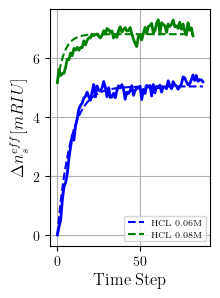

In [10]:
# Estimate the state (y_hat) for all experiments
y_hat_list = []
for exp_idx in range(n_experiments):
    final_ka = ka_final_list[exp_idx]
    final_kd = kd_final_list[exp_idx]
    final_theta_inf = theta_inf_final_list[exp_idx]
    dt = dt_list[exp_idx]
    dt = np.append(dt, dt[-1])
    y = y_list[exp_idx]
    K_a = final_ka / final_kd
    u = u_list[exp_idx]
    n_points = len(y_list[exp_idx])
    y_hat = np.zeros(n_points)  # Initialize estimated state
    y_hat[0] = y_list[exp_idx][0]  # Match initial condition

    for k in range(1, n_points):
        y_hat[k] = y_hat[k - 1] + dt[k] * (
            final_ka * u[k - 1] * (final_theta_inf - y_hat[k - 1])
            - final_kd * y_hat[k - 1]
        )

    y_hat_list.append(y_hat)
    N_max = (y_hat[-1] * (u[-1] + 1 / K_a)) / (u[-1] * final_theta_inf)

plt.rc("axes", titlesize=14)  # Title font size
plt.rc("axes", labelsize=14)  # Label font size
plt.rc("xtick", labelsize=12)  # X-tick font size
plt.rc("ytick", labelsize=12)  # Y-tick font size
plt.rc("legend", fontsize=12)  # Legend font size

# Define a list of colors for each experiment
colors = [
    "blue",
    "green",
    "red",
    "orange",
    "purple",
    "brown",
    "pink",
    "cyan",
]  # Extend if needed

plt.rc("axes", titlesize=12, labelsize=12)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.rc("legend", fontsize=9) # Slightly larger for readability in individual plots

# Create the figure with the correct aspect ratio
# Each plot is 6cm wide (18cm / 3) and we'll choose 8cm for the height.
# 1 inch = 2.54 cm
width_cm = 6
height_cm = 8
plt.figure(figsize=(width_cm / 2.54, height_cm / 2.54))

for exp_idx in range(n_experiments):
    color = colors[exp_idx % len(colors)]  # Cycle colors if needed
    n_points = len(y_list[exp_idx])
    final_ka = ka_final_list[exp_idx]
    final_kd = kd_final_list[exp_idx]
    final_theta_inf = theta_inf_final_list[exp_idx]
    dt = dt_list[exp_idx]
    dt = np.append(dt, dt[-1])
    y = y_list[exp_idx]
    K_a = final_ka / final_kd
    u = u_list[exp_idx]
    y_hat = y_hat_list[exp_idx]
    N_max = (np.array(y)[-1] * (u[-1] + 1 / K_a)) / (u[-1] * final_theta_inf)
    MSE_value = (1/2)*np.sum((y_hat-y)**2)
    print(
        "ka",
        final_ka * N_max,
        "kd",
        final_kd * N_max,
        "thetainf",
        final_theta_inf/N_max,
        "KA",
        final_ka / final_kd,
        "Nmax",
        N_max,
        "LS",
        MSE_value
    )
    # Format constants for the legend
    # if exp_idx == 0:
    #     legend_label = (
    #         f"HCL 0.06M:"
    #         f" $k_a$={final_ka * N_max:.2e},"
    #         f" $k_d$={final_kd * N_max:.2e},"
    #         f" LS = {MSE_value:.2e}"
    #     )
    # else:
    #     legend_label = (    
    #         f"HCL 0.08M:"
    #         f" $k_a$={final_ka * N_max:.2e},"
    #         f" $k_d$={final_kd * N_max:.2e},"
    #         f" LS = {MSE_value:.2e}"
    #     )
    if exp_idx == 0:
        legend_label = (
            f"HCL 0.06M"
        )
    else:
        legend_label = (    
            f"HCL 0.08M"
        )
    # Plot actual state
    plt.plot(
        range(n_points),
        y_list[exp_idx] * 1e3,
        # label=f"Actual State (Exp {exp_idx + 1})",
        color=color,
        linewidth=2,
    )

    # Plot estimated state
    plt.plot(
        range(n_points),
        y_hat_list[exp_idx] * 1e3,
        label=legend_label,
        color=color,
        linestyle="--",
        linewidth=1.5,
    )

# Configure axis labels, legend, and grid
plt.xlabel("Time Step")
plt.ylabel(r"$\Delta n_s^{eff} [mRIU]$")
plt.legend(loc="best", fontsize=6)
plt.grid(True)
plt.rc("font", family="times new roman", size=12)  # Use the default serif font


# Display the plot
plt.tight_layout()
plt.savefig("estimated_state_HCL.png", dpi=300, bbox_inches='tight')
plt.show()

Successfully created and saved combined_figure.pdf with labels in titles.


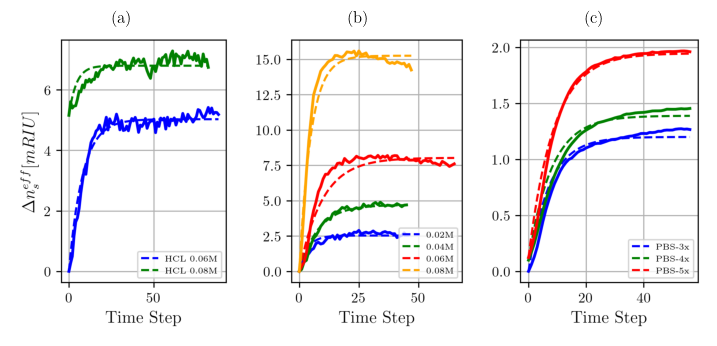

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# --- 1. Define the final figure layout ---

# The final figure will have a total width of 18 cm.
# The height will be 8 cm to match the aspect ratio of the individual plots.
fig, axes = plt.subplots(1, 3, figsize=(18 / 2.54, 8 / 2.54))

# --- 2. Load and display each saved plot ---

# List of image filenames and their corresponding labels
image_files = [
        'estimated_state_HCL.png',
    'estimated_state_NaOH.png',
    'estimated_state_PBS.png',

]
panel_labels = ['(a)', '(b)', '(c)']

for i, ax in enumerate(axes):
    # Read the saved PNG image
    img = mpimg.imread(image_files[i])

    # Display the image on the subplot axis
    ax.imshow(img)

    # --- CHANGE: Set the label as the subplot title ---
    # The label is now placed as a title, positioned to the left.
    ax.set_title(panel_labels[i], loc='center', fontsize=12, fontweight='bold')

    # Turn off the axis lines and ticks from the subplot containers
    ax.axis('off')

# --- 3. Adjust layout and save the final figure ---

# Adjust layout to ensure titles are spaced nicely
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

# Save the final combined figure as a high-quality PDF
plt.savefig("combined_figure.pdf", dpi=300, bbox_inches='tight')
plt.savefig("combined_figure.png", dpi=300, bbox_inches='tight') # Also save as PNG

print("Successfully created and saved combined_figure.pdf with labels in titles.")

plt.show()